In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

C:\Users\USER\anaconda3\envs\dacon-housing-price\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
path = './input'
dirs = os.listdir(path)
for file in dirs:
    print(file)

sample_submission.csv
test.csv
train.csv


In [3]:
# Import Files
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

# Data Cleaning

In [4]:
train.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


In [5]:
train = train.drop(['id'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Overall Qual    1350 non-null   int64 
 1   Gr Liv Area     1350 non-null   int64 
 2   Exter Qual      1350 non-null   object
 3   Garage Cars     1350 non-null   int64 
 4   Garage Area     1350 non-null   int64 
 5   Kitchen Qual    1350 non-null   object
 6   Total Bsmt SF   1350 non-null   int64 
 7   1st Flr SF      1350 non-null   int64 
 8   Bsmt Qual       1350 non-null   object
 9   Full Bath       1350 non-null   int64 
 10  Year Built      1350 non-null   int64 
 11  Year Remod/Add  1350 non-null   int64 
 12  Garage Yr Blt   1350 non-null   int64 
 13  target          1350 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 147.8+ KB


- `id` : 데이터 고유 id
- `OverallQual` : 전반적 재료와 마감 품질
- `YearBuilt` : 완공 연도
- `YearRemodAdd` : 리모델링 연도
- `ExterQual` : 외관 재료 품질
- `BsmtQual` : 지하실 높이
- `TotalBsmtSF` : 지하실 면적
- `1stFlrSF` : 1층 면적
- `GrLivArea` : 지상층 생활 면적
- `FullBath` : 지상층 화장실 개수
- `KitchenQual` : 부억 품질
- `GarageYrBlt` : 차고 완공 연도
- `GarageCars`: 차고 자리 개수
- `GarageArea`: 차고 면적
- `target` : 집값(달러 단위)

In [6]:
train.isnull().sum()

Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
target            0
dtype: int64

In [7]:
test.isnull().sum()

id                0
Overall Qual      0
Gr Liv Area       0
Exter Qual        0
Garage Cars       0
Garage Area       0
Kitchen Qual      0
Total Bsmt SF     0
1st Flr SF        0
Bsmt Qual         0
Full Bath         0
Year Built        0
Year Remod/Add    0
Garage Yr Blt     0
dtype: int64

train data 와 test data 모두에 결측치가 존재하지 않는다.

In [8]:
continuous_features = list(train.columns[train.dtypes=='int64'])
categorical_features = list(train.columns[train.dtypes=='object'])

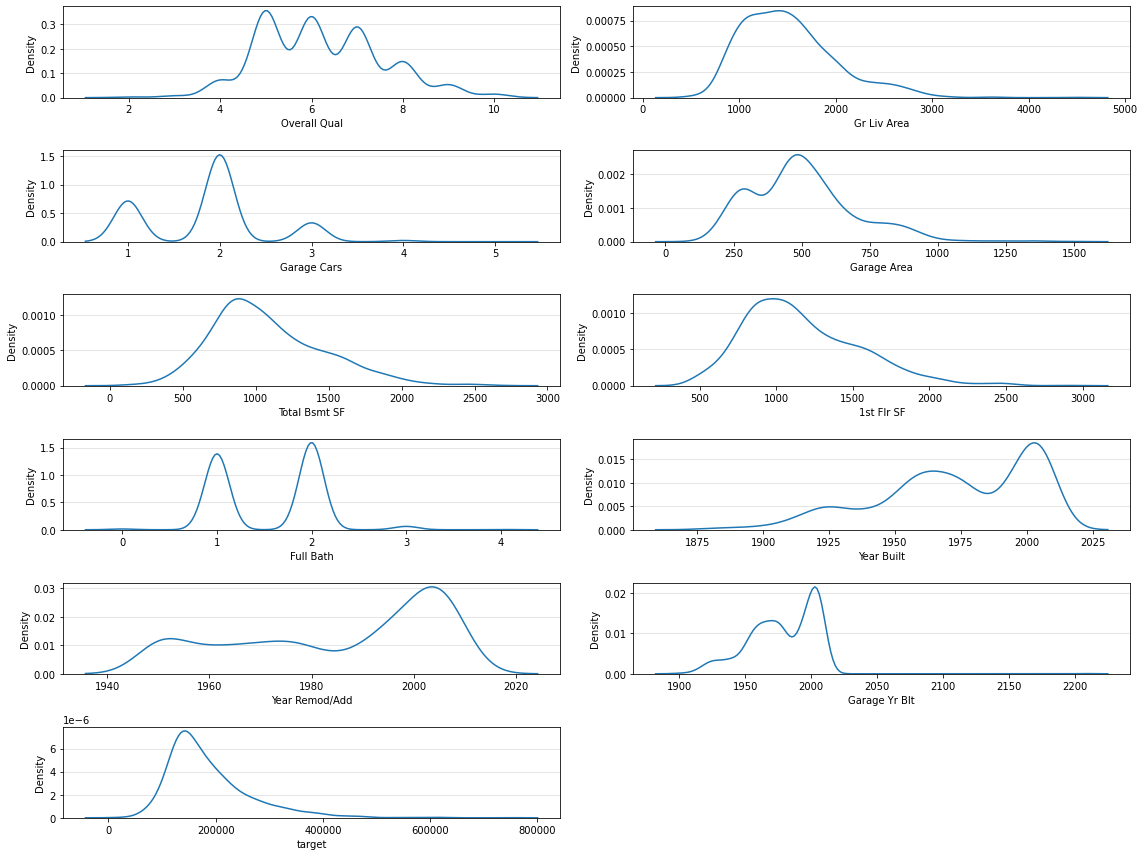

In [9]:
## Distribution of other continuous variables
plt.figure(figsize=(16,12))

for i, col in enumerate(continuous_features):
    ax = plt.subplot(6,2,i+1)
    sns.kdeplot(train[col])
    ax.grid(axis='y', linestyle='-', alpha=0.4)
    plt.tight_layout()

면적과 관련된 지표들은 일관되게 좌측으로 치우쳐 있다.
- `TotalBsmtSF`(지하실 면적) : 좌측으로 치우쳐 있음
- `1stFlrSF`(1층 면적) : 좌측으로 치우쳐 있음
- `GrLivArea`(지상층 생활 면적) : 좌측으로 치우쳐 있음
- `GarageArea`(차고 면적) : 좌측으로 치우쳐 있음

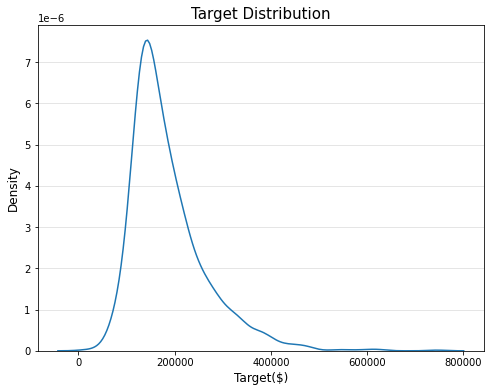

In [10]:
## Distribution of target variable
plt.figure(figsize=(8,6))
sns.kdeplot(train['target'])
plt.title('Target Distribution', fontsize=15)
plt.xlabel('Target($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.4)

target 변수가 좌측으로 치우쳐져 있으므로 log scale 로 변환한 다음 분석을 진행한다.

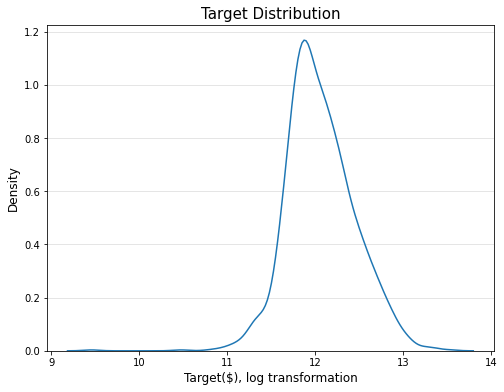

In [11]:
plt.figure(figsize=(8,6))
sns.kdeplot(np.log1p(train['target']))
plt.title('Target Distribution', fontsize=15)
plt.xlabel('Target($), log transformation', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.4)

In [12]:
train['target'] = np.log1p(train['target'])

In [13]:
## Number of unique categories of categorical variables
for col in categorical_features:
    print('Number of unique categories of %s : %s'%(col, train[col].value_counts().nunique()))

Number of unique categories of Exter Qual : 4
Number of unique categories of Kitchen Qual : 4
Number of unique categories of Bsmt Qual : 5


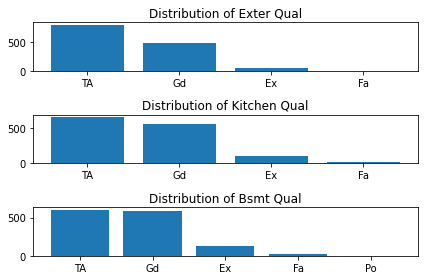

In [14]:
for i, col in enumerate(categorical_features):
    ax = plt.subplot(3, 1, i+1)
    plt.bar(list(train[col].value_counts().index), list(train[col].value_counts().values))
    plt.title('Distribution of %s'%col)
    plt.tight_layout()

- `TA` : Typical/Average
- `Gd` : Good
- `Ex` : Excellent
- `Fa` : Fair
- `Po` : Poor

Quality 를 나타내는 지표들은 보통~좋음 수준에 몰려있는 특징이 있다.

Quality 를 나타내는 지표들은 애초에 ordinal 한 특성을 가지고 있는 qualitative variable 이므로 one-hot encoding 대신에 label encoding 을 해 주어도 된다.

In [15]:
def label_encoder(data):
    le = LabelEncoder()
    le_count = 0
    for column in data:
        if data[column].dtype == 'object':
            le.fit(data[column])
            data[column] = le.transform(data[column])
            le_count += 1
    print('%d columns were label encoded'%le_count)
    return data

In [16]:
label_encoder(train)

3 columns were label encoded


,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,10,2392,0,3,968,0,2392,2392,0,2,2003,2003,2003,12.864243
1,7,1352,2,2,466,2,1352,1352,0,2,2006,2007,2006,12.175619
2,5,900,3,1,288,3,864,900,4,1,1967,1967,1967,11.719948
3,5,1174,3,2,576,2,680,680,4,1,1900,2006,2000,11.813037
4,7,1958,2,3,936,2,1026,1026,2,2,2005,2005,2005,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,6,1756,2,2,422,3,872,888,0,2,1996,1997,1996,12.225880
1346,9,2748,2,3,850,0,1850,1850,0,2,2006,2006,2006,12.873905
1347,5,1214,3,1,318,3,1214,1214,4,2,1967,1967,1967,11.870607
1348,5,894,3,2,440,3,864,894,2,1,1974,1974,1974,11.782960


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Overall Qual    1350 non-null   int64  
 1   Gr Liv Area     1350 non-null   int64  
 2   Exter Qual      1350 non-null   int32  
 3   Garage Cars     1350 non-null   int64  
 4   Garage Area     1350 non-null   int64  
 5   Kitchen Qual    1350 non-null   int32  
 6   Total Bsmt SF   1350 non-null   int64  
 7   1st Flr SF      1350 non-null   int64  
 8   Bsmt Qual       1350 non-null   int32  
 9   Full Bath       1350 non-null   int64  
 10  Year Built      1350 non-null   int64  
 11  Year Remod/Add  1350 non-null   int64  
 12  Garage Yr Blt   1350 non-null   int64  
 13  target          1350 non-null   float64
dtypes: float64(1), int32(3), int64(10)
memory usage: 132.0 KB


In [18]:
def corr_heatmap(data):
    correlations = data[data.columns].corr()
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidth=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show()

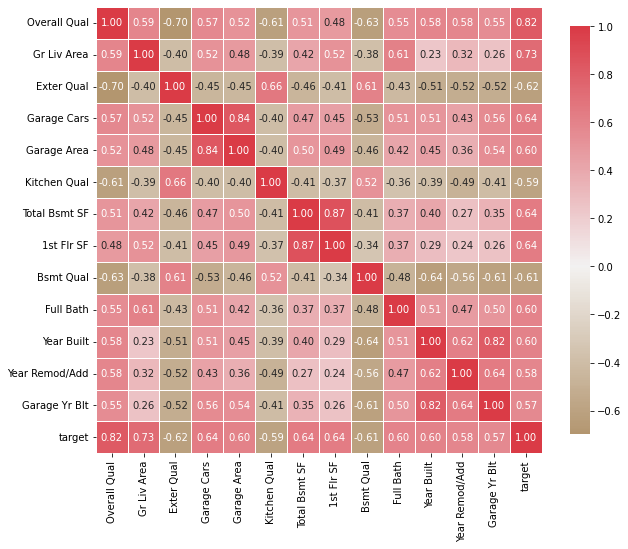

In [19]:
corr_heatmap(train)

`Target`이 가장 높은 상관을 보이는 변수는 `Overall Qual`로, 상관계수는 0.81이다.

# Feature Engineering

## Polynomial features?

In [20]:
poly_cols = ['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Area']
poly_features = train[poly_cols]
poly_target = train['target']
print('Features shape :', poly_features.shape)
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(poly_features)

Features shape : (1350, 5)


PolynomialFeatures()

In [21]:
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape :', poly_features.shape)

Polynomial Features shape : (1350, 21)


In [22]:
poly_transformer.get_feature_names(input_features=poly_cols)

['1',
 'Overall Qual',
 'Gr Liv Area',
 'Total Bsmt SF',
 '1st Flr SF',
 'Garage Area',
 'Overall Qual^2',
 'Overall Qual Gr Liv Area',
 'Overall Qual Total Bsmt SF',
 'Overall Qual 1st Flr SF',
 'Overall Qual Garage Area',
 'Gr Liv Area^2',
 'Gr Liv Area Total Bsmt SF',
 'Gr Liv Area 1st Flr SF',
 'Gr Liv Area Garage Area',
 'Total Bsmt SF^2',
 'Total Bsmt SF 1st Flr SF',
 'Total Bsmt SF Garage Area',
 '1st Flr SF^2',
 '1st Flr SF Garage Area',
 'Garage Area^2']

In [23]:
poly_features = pd.DataFrame(poly_features,
                             columns=poly_transformer.get_feature_names(poly_cols))
poly_features['target'] = poly_target

In [24]:
poly_features.corr()['target'].sort_values(ascending=False)

target                        1.000000
Overall Qual Gr Liv Area      0.848770
Overall Qual                  0.824001
Overall Qual^2                0.821173
Overall Qual 1st Flr SF       0.805987
Overall Qual Total Bsmt SF    0.795861
Gr Liv Area Total Bsmt SF     0.783295
Overall Qual Garage Area      0.782917
Gr Liv Area Garage Area       0.757610
Gr Liv Area 1st Flr SF        0.748049
Gr Liv Area                   0.732123
Total Bsmt SF Garage Area     0.705800
1st Flr SF Garage Area        0.703213
Gr Liv Area^2                 0.691501
Total Bsmt SF 1st Flr SF      0.650060
Total Bsmt SF                 0.643634
Total Bsmt SF^2               0.640633
1st Flr SF                    0.635290
1st Flr SF^2                  0.619998
Garage Area                   0.602254
Garage Area^2                 0.546227
1                                  NaN
Name: target, dtype: float64

In [25]:
poly_features.corr()['target']

1                                  NaN
Overall Qual                  0.824001
Gr Liv Area                   0.732123
Total Bsmt SF                 0.643634
1st Flr SF                    0.635290
Garage Area                   0.602254
Overall Qual^2                0.821173
Overall Qual Gr Liv Area      0.848770
Overall Qual Total Bsmt SF    0.795861
Overall Qual 1st Flr SF       0.805987
Overall Qual Garage Area      0.782917
Gr Liv Area^2                 0.691501
Gr Liv Area Total Bsmt SF     0.783295
Gr Liv Area 1st Flr SF        0.748049
Gr Liv Area Garage Area       0.757610
Total Bsmt SF^2               0.640633
Total Bsmt SF 1st Flr SF      0.650060
Total Bsmt SF Garage Area     0.705800
1st Flr SF^2                  0.619998
1st Flr SF Garage Area        0.703213
Garage Area^2                 0.546227
target                        1.000000
Name: target, dtype: float64

In [26]:
poly_features.corr()['target'].index

Index(['1', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF',
       'Garage Area', 'Overall Qual^2', 'Overall Qual Gr Liv Area',
       'Overall Qual Total Bsmt SF', 'Overall Qual 1st Flr SF',
       'Overall Qual Garage Area', 'Gr Liv Area^2',
       'Gr Liv Area Total Bsmt SF', 'Gr Liv Area 1st Flr SF',
       'Gr Liv Area Garage Area', 'Total Bsmt SF^2',
       'Total Bsmt SF 1st Flr SF', 'Total Bsmt SF Garage Area', '1st Flr SF^2',
       '1st Flr SF Garage Area', 'Garage Area^2', 'target'],
      dtype='object')

In [27]:
list(poly_features.corr()['target'].index)

['1',
 'Overall Qual',
 'Gr Liv Area',
 'Total Bsmt SF',
 '1st Flr SF',
 'Garage Area',
 'Overall Qual^2',
 'Overall Qual Gr Liv Area',
 'Overall Qual Total Bsmt SF',
 'Overall Qual 1st Flr SF',
 'Overall Qual Garage Area',
 'Gr Liv Area^2',
 'Gr Liv Area Total Bsmt SF',
 'Gr Liv Area 1st Flr SF',
 'Gr Liv Area Garage Area',
 'Total Bsmt SF^2',
 'Total Bsmt SF 1st Flr SF',
 'Total Bsmt SF Garage Area',
 '1st Flr SF^2',
 '1st Flr SF Garage Area',
 'Garage Area^2',
 'target']

In [28]:
train_poly = poly_features[['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF',
                            '1st Flr SF','Garage Area', 'Overall Qual^2',
                            'Overall Qual Gr Liv Area','Overall Qual Total Bsmt SF',
                            'Overall Qual 1st Flr SF', 'Overall Qual Garage Area',
                            'Gr Liv Area^2', 'Gr Liv Area Total Bsmt SF',
                            'Gr Liv Area 1st Flr SF', 'Gr Liv Area Garage Area',
                            'Total Bsmt SF^2', 'Total Bsmt SF 1st Flr SF',
                            'Total Bsmt SF Garage Area', '1st Flr SF^2',
                            '1st Flr SF Garage Area', 'Garage Area^2', 'target']]

In [29]:
train_all = train.merge(train_poly, on='target', how='left')

In [30]:
train_all.shape

(5970, 34)

# Model

In [31]:
X = train_all.drop('target', axis=1)
y = train_all['target']

## XGBoostRegressor

In [32]:
def objectiveXGB(trial: Trial, X, y):

    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method' : 'gpu_hist',
        'predictor' : 'gpu_predictor',
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha' : trial.suggest_loguniform('aplha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state' : 42
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    model = xgb.XGBRegressor(**params)
    xgb_model = model.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
    score = mean_squared_error(xgb_model.predict(X_test), y_test, squared=False)

    return score

In [33]:
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objectiveXGB(trial, X, y), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study.best_trial.values, study.best_trial.params))

[I 2022-01-29 18:16:09,770] A new study created in memory with name: no-name-fe87b0b8-71cf-44ef-84af-e044c68096ef
[I 2022-01-29 18:16:18,323] Trial 0 finished with value: 0.1104403352053414 and parameters: {'n_estimators': 3851, 'max_depth': 16, 'min_child_weight': 11, 'gamma': 2, 'colsample_bytree': 0.9, 'lambda': 0.0035702544866957633, 'aplha': 0.003570924574052772, 'subsample': 0.6}. Best is trial 0 with value: 0.1104403352053414.
[I 2022-01-29 18:16:25,504] Trial 1 finished with value: 0.11194069098022237 and parameters: {'n_estimators': 3053, 'max_depth': 12, 'min_child_weight': 69, 'gamma': 3, 'colsample_bytree': 0.6, 'lambda': 0.0011142261439587417, 'aplha': 0.04617651281961141, 'subsample': 0.8}. Best is trial 0 with value: 0.1104403352053414.
[I 2022-01-29 18:16:27,351] Trial 2 finished with value: 0.11787484488010957 and parameters: {'n_estimators': 881, 'max_depth': 8, 'min_child_weight': 219, 'gamma': 3, 'colsample_bytree': 0.9, 'lambda': 0.02079181739600767, 'aplha': 0.009

Best trial: score [0.09673397262978066],
params {'n_estimators': 2623, 'max_depth': 10, 'min_child_weight': 58, 'gamma': 1, 'colsample_bytree': 1.0, 'lambda': 0.01668391418732973, 'aplha': 0.001699168154265597, 'subsample': 0.7}


In [34]:
xgb_trial = study.best_trial
xgb_trial_params = xgb_trial.params
print('Best Trial: score {},\nparams {}'.format(xgb_trial.value, xgb_trial_params))

Best Trial: score 0.09673397262978066,
params {'n_estimators': 2623, 'max_depth': 10, 'min_child_weight': 58, 'gamma': 1, 'colsample_bytree': 1.0, 'lambda': 0.01668391418732973, 'aplha': 0.001699168154265597, 'subsample': 0.7}


## LGBMRegressor

In [35]:
def objectiveLGBMRegressor(trial: Trial, X, y):

    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha' : trial.suggest_loguniform('aplha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state' : 42
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    model = LGBMRegressor(**params)
    lgbm_model = model.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
    score = mean_squared_error(lgbm_model.predict(X_test), y_test, squared=False)

    return score

In [36]:
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objectiveLGBMRegressor(trial, X, y), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study.best_trial.values, study.best_trial.params))

[I 2022-01-29 18:24:41,631] A new study created in memory with name: no-name-5d2ce8a9-01a0-4338-88e4-87ada0b543b7


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.0013074823245140725. Current value: lambda_l2=0.0013074823245140725


[I 2022-01-29 18:24:42,471] Trial 0 finished with value: 0.08489902144363967 and parameters: {'n_estimators': 1686, 'max_depth': 11, 'min_child_weight': 180, 'colsample_bytree': 0.7, 'lambda': 0.0013074823245140725, 'aplha': 1.2073443215020232, 'subsample': 0.7}. Best is trial 0 with value: 0.08489902144363967.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.0538423928924027. Current value: lambda_l2=0.0538423928924027


[I 2022-01-29 18:24:43,156] Trial 1 finished with value: 0.09974202708992563 and parameters: {'n_estimators': 1667, 'max_depth': 10, 'min_child_weight': 283, 'colsample_bytree': 0.7, 'lambda': 0.0538423928924027, 'aplha': 0.017877597895227592, 'subsample': 0.7}. Best is trial 0 with value: 0.08489902144363967.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.18085539841695228. Current value: lambda_l2=0.18085539841695228


[I 2022-01-29 18:24:43,812] Trial 2 finished with value: 0.07888444303110874 and parameters: {'n_estimators': 937, 'max_depth': 13, 'min_child_weight': 106, 'colsample_bytree': 0.9, 'lambda': 0.18085539841695228, 'aplha': 0.002522342985050428, 'subsample': 0.7}. Best is trial 2 with value: 0.07888444303110874.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.003790068036452742. Current value: lambda_l2=0.003790068036452742


[I 2022-01-29 18:24:44,961] Trial 3 finished with value: 0.06639039592745186 and parameters: {'n_estimators': 2023, 'max_depth': 11, 'min_child_weight': 12, 'colsample_bytree': 0.6, 'lambda': 0.003790068036452742, 'aplha': 0.016152976327952297, 'subsample': 0.8}. Best is trial 3 with value: 0.06639039592745186.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.006440520504610903. Current value: lambda_l2=0.006440520504610903


[I 2022-01-29 18:24:45,636] Trial 4 finished with value: 0.09326709403639882 and parameters: {'n_estimators': 1064, 'max_depth': 13, 'min_child_weight': 10, 'colsample_bytree': 0.6, 'lambda': 0.006440520504610903, 'aplha': 0.705658179648431, 'subsample': 0.7}. Best is trial 3 with value: 0.06639039592745186.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.005381849530781925. Current value: lambda_l2=0.005381849530781925


[I 2022-01-29 18:24:47,379] Trial 5 finished with value: 0.07446462133912785 and parameters: {'n_estimators': 3721, 'max_depth': 11, 'min_child_weight': 223, 'colsample_bytree': 0.9, 'lambda': 0.005381849530781925, 'aplha': 0.25979717051082646, 'subsample': 0.7}. Best is trial 3 with value: 0.06639039592745186.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.0014273582233607042. Current value: lambda_l2=0.0014273582233607042


[I 2022-01-29 18:24:47,927] Trial 6 finished with value: 0.07740289532513149 and parameters: {'n_estimators': 1211, 'max_depth': 9, 'min_child_weight': 181, 'colsample_bytree': 0.8, 'lambda': 0.0014273582233607042, 'aplha': 0.2610717371584995, 'subsample': 0.7}. Best is trial 3 with value: 0.06639039592745186.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.5177806858706546. Current value: lambda_l2=2.5177806858706546


[I 2022-01-29 18:24:49,410] Trial 7 finished with value: 0.08307523563030711 and parameters: {'n_estimators': 3959, 'max_depth': 8, 'min_child_weight': 174, 'colsample_bytree': 0.5, 'lambda': 2.5177806858706546, 'aplha': 0.547890139457756, 'subsample': 1.0}. Best is trial 3 with value: 0.06639039592745186.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.0037567890256364205. Current value: lambda_l2=0.0037567890256364205


[I 2022-01-29 18:24:51,080] Trial 8 finished with value: 0.06697953480358833 and parameters: {'n_estimators': 3879, 'max_depth': 8, 'min_child_weight': 53, 'colsample_bytree': 0.7, 'lambda': 0.0037567890256364205, 'aplha': 0.34522436607552587, 'subsample': 1.0}. Best is trial 3 with value: 0.06639039592745186.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.026891949773125253. Current value: lambda_l2=0.026891949773125253


[I 2022-01-29 18:24:51,838] Trial 9 finished with value: 0.06559494285791106 and parameters: {'n_estimators': 1283, 'max_depth': 12, 'min_child_weight': 23, 'colsample_bytree': 0.5, 'lambda': 0.026891949773125253, 'aplha': 0.003263906612810072, 'subsample': 0.8}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.09511324148407771. Current value: lambda_l2=0.09511324148407771


[I 2022-01-29 18:24:53,494] Trial 10 finished with value: 0.07383718673668682 and parameters: {'n_estimators': 2686, 'max_depth': 16, 'min_child_weight': 98, 'colsample_bytree': 0.5, 'lambda': 0.09511324148407771, 'aplha': 5.796327095250901, 'subsample': 0.6}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.022914411188296627. Current value: lambda_l2=0.022914411188296627


[I 2022-01-29 18:24:54,996] Trial 11 finished with value: 0.06665804170053853 and parameters: {'n_estimators': 2546, 'max_depth': 14, 'min_child_weight': 1, 'colsample_bytree': 0.5, 'lambda': 0.022914411188296627, 'aplha': 0.01474498082319911, 'subsample': 0.8}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5196857532474851. Current value: lambda_l2=0.5196857532474851


[I 2022-01-29 18:24:55,376] Trial 12 finished with value: 0.0799467720059648 and parameters: {'n_estimators': 502, 'max_depth': 12, 'min_child_weight': 60, 'colsample_bytree': 0.6, 'lambda': 0.5196857532474851, 'aplha': 0.0011352392132798345, 'subsample': 0.8}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.023999328236479378. Current value: lambda_l2=0.023999328236479378


[I 2022-01-29 18:24:56,642] Trial 13 finished with value: 0.0733338177138451 and parameters: {'n_estimators': 2053, 'max_depth': 14, 'min_child_weight': 51, 'colsample_bytree': 0.6, 'lambda': 0.023999328236479378, 'aplha': 0.015959809167308308, 'subsample': 0.8}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.01867217443569657. Current value: lambda_l2=0.01867217443569657


[I 2022-01-29 18:24:58,368] Trial 14 finished with value: 0.08949227699899676 and parameters: {'n_estimators': 3153, 'max_depth': 11, 'min_child_weight': 113, 'colsample_bytree': 1.0, 'lambda': 0.01867217443569657, 'aplha': 0.005585676050478881, 'subsample': 0.8}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.3547003969866159. Current value: lambda_l2=0.3547003969866159


[I 2022-01-29 18:24:59,744] Trial 15 finished with value: 0.0683293919458057 and parameters: {'n_estimators': 2141, 'max_depth': 16, 'min_child_weight': 42, 'colsample_bytree': 0.6, 'lambda': 0.3547003969866159, 'aplha': 0.0392885569424986, 'subsample': 0.8}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.009694867469706419. Current value: lambda_l2=0.009694867469706419


[I 2022-01-29 18:25:00,557] Trial 16 finished with value: 0.09748461507060395 and parameters: {'n_estimators': 1527, 'max_depth': 10, 'min_child_weight': 86, 'colsample_bytree': 0.5, 'lambda': 0.009694867469706419, 'aplha': 0.07337243540473798, 'subsample': 0.6}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.9883326988241565. Current value: lambda_l2=2.9883326988241565


[I 2022-01-29 18:25:00,955] Trial 17 finished with value: 0.08428387944286443 and parameters: {'n_estimators': 621, 'max_depth': 12, 'min_child_weight': 134, 'colsample_bytree': 0.6, 'lambda': 2.9883326988241565, 'aplha': 0.003836794923610677, 'subsample': 0.8}. Best is trial 9 with value: 0.06559494285791106.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=9.192265054043993. Current value: lambda_l2=9.192265054043993


[I 2022-01-29 18:25:02,856] Trial 18 finished with value: 0.06461563319309946 and parameters: {'n_estimators': 2869, 'max_depth': 14, 'min_child_weight': 23, 'colsample_bytree': 0.8, 'lambda': 9.192265054043993, 'aplha': 0.0010295316108561092, 'subsample': 0.8}. Best is trial 18 with value: 0.06461563319309946.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.9046693436878405. Current value: lambda_l2=0.9046693436878405


[I 2022-01-29 18:25:04,428] Trial 19 finished with value: 0.07761844602824565 and parameters: {'n_estimators': 3233, 'max_depth': 15, 'min_child_weight': 240, 'colsample_bytree': 0.9, 'lambda': 0.9046693436878405, 'aplha': 0.0010109410261025153, 'subsample': 0.8}. Best is trial 18 with value: 0.06461563319309946.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=5.297949738007397. Current value: lambda_l2=5.297949738007397


[I 2022-01-29 18:25:06,123] Trial 20 finished with value: 0.07102197447916857 and parameters: {'n_estimators': 2622, 'max_depth': 14, 'min_child_weight': 72, 'colsample_bytree': 0.8, 'lambda': 5.297949738007397, 'aplha': 0.005624167369379787, 'subsample': 0.6}. Best is trial 18 with value: 0.06461563319309946.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=9.848070055541701. Current value: lambda_l2=9.848070055541701


[I 2022-01-29 18:25:08,102] Trial 21 finished with value: 0.062160430134584235 and parameters: {'n_estimators': 3076, 'max_depth': 13, 'min_child_weight': 22, 'colsample_bytree': 0.8, 'lambda': 9.848070055541701, 'aplha': 0.0019697293705218774, 'subsample': 0.8}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=8.897185129601045. Current value: lambda_l2=8.897185129601045


[I 2022-01-29 18:25:10,129] Trial 22 finished with value: 0.06714721634161537 and parameters: {'n_estimators': 3142, 'max_depth': 13, 'min_child_weight': 34, 'colsample_bytree': 0.8, 'lambda': 8.897185129601045, 'aplha': 0.00199054174108782, 'subsample': 0.8}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.2722000540059653. Current value: lambda_l2=1.2722000540059653


[I 2022-01-29 18:25:12,259] Trial 23 finished with value: 0.06527440673142107 and parameters: {'n_estimators': 3449, 'max_depth': 13, 'min_child_weight': 31, 'colsample_bytree': 0.8, 'lambda': 1.2722000540059653, 'aplha': 0.006622564500929293, 'subsample': 0.8}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.5891508278615745. Current value: lambda_l2=2.5891508278615745


[I 2022-01-29 18:25:14,433] Trial 24 finished with value: 0.06419943885968767 and parameters: {'n_estimators': 3457, 'max_depth': 15, 'min_child_weight': 82, 'colsample_bytree': 0.8, 'lambda': 2.5891508278615745, 'aplha': 0.007852802297964175, 'subsample': 1.0}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=9.868620526367996. Current value: lambda_l2=9.868620526367996


[I 2022-01-29 18:25:16,511] Trial 25 finished with value: 0.07119648598856072 and parameters: {'n_estimators': 2970, 'max_depth': 15, 'min_child_weight': 77, 'colsample_bytree': 1.0, 'lambda': 9.868620526367996, 'aplha': 0.0016594320652691308, 'subsample': 1.0}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.043275352679576. Current value: lambda_l2=4.043275352679576


[I 2022-01-29 18:25:18,763] Trial 26 finished with value: 0.07703461156306403 and parameters: {'n_estimators': 3472, 'max_depth': 15, 'min_child_weight': 132, 'colsample_bytree': 0.9, 'lambda': 4.043275352679576, 'aplha': 0.008986543965694238, 'subsample': 1.0}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.1043438635142504. Current value: lambda_l2=2.1043438635142504


[I 2022-01-29 18:25:20,572] Trial 27 finished with value: 0.07385818656155507 and parameters: {'n_estimators': 2890, 'max_depth': 14, 'min_child_weight': 65, 'colsample_bytree': 0.8, 'lambda': 2.1043438635142504, 'aplha': 0.0728235538670246, 'subsample': 1.0}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=5.470696366473171. Current value: lambda_l2=5.470696366473171


[I 2022-01-29 18:25:22,806] Trial 28 finished with value: 0.06732055093720411 and parameters: {'n_estimators': 3561, 'max_depth': 15, 'min_child_weight': 34, 'colsample_bytree': 0.7, 'lambda': 5.470696366473171, 'aplha': 0.02966607842472129, 'subsample': 1.0}. Best is trial 21 with value: 0.062160430134584235.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.2029343433795698. Current value: lambda_l2=1.2029343433795698


[I 2022-01-29 18:25:24,349] Trial 29 finished with value: 0.06162182414744128 and parameters: {'n_estimators': 2436, 'max_depth': 16, 'min_child_weight': 2, 'colsample_bytree': 0.7, 'lambda': 1.2029343433795698, 'aplha': 6.632324911467629, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.2293706092809529. Current value: lambda_l2=1.2293706092809529


[I 2022-01-29 18:25:25,759] Trial 30 finished with value: 0.09242226459344499 and parameters: {'n_estimators': 2393, 'max_depth': 16, 'min_child_weight': 163, 'colsample_bytree': 0.7, 'lambda': 1.2293706092809529, 'aplha': 3.0756500367474815, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.446594727632599. Current value: lambda_l2=6.446594727632599


[I 2022-01-29 18:25:27,649] Trial 31 finished with value: 0.06417607022582339 and parameters: {'n_estimators': 2769, 'max_depth': 16, 'min_child_weight': 5, 'colsample_bytree': 0.8, 'lambda': 6.446594727632599, 'aplha': 1.1909288996643859, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.8124108324855168. Current value: lambda_l2=1.8124108324855168


[I 2022-01-29 18:25:29,173] Trial 32 finished with value: 0.08204066961489684 and parameters: {'n_estimators': 2362, 'max_depth': 16, 'min_child_weight': 8, 'colsample_bytree': 0.7, 'lambda': 1.8124108324855168, 'aplha': 1.7615871031112025, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5415040689342476. Current value: lambda_l2=0.5415040689342476


[I 2022-01-29 18:25:30,457] Trial 33 finished with value: 0.068774874600707 and parameters: {'n_estimators': 1844, 'max_depth': 15, 'min_child_weight': 5, 'colsample_bytree': 0.7, 'lambda': 0.5415040689342476, 'aplha': 4.192142154988638, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.22151031640477759. Current value: lambda_l2=0.22151031640477759


[I 2022-01-29 18:25:31,911] Trial 34 finished with value: 0.07676923288316372 and parameters: {'n_estimators': 3268, 'max_depth': 16, 'min_child_weight': 291, 'colsample_bytree': 0.9, 'lambda': 0.22151031640477759, 'aplha': 1.780649515283272, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.7654787521067297. Current value: lambda_l2=3.7654787521067297


[I 2022-01-29 18:25:33,772] Trial 35 finished with value: 0.0795536137182543 and parameters: {'n_estimators': 2825, 'max_depth': 15, 'min_child_weight': 47, 'colsample_bytree': 0.8, 'lambda': 3.7654787521067297, 'aplha': 7.065780379854164, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0824061210144524. Current value: lambda_l2=1.0824061210144524


[I 2022-01-29 18:25:36,227] Trial 36 finished with value: 0.08342733269156032 and parameters: {'n_estimators': 3691, 'max_depth': 16, 'min_child_weight': 89, 'colsample_bytree': 0.9, 'lambda': 1.0824061210144524, 'aplha': 9.986454773031172, 'subsample': 1.0}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=5.90695177747382. Current value: lambda_l2=5.90695177747382


[I 2022-01-29 18:25:38,212] Trial 37 finished with value: 0.06377932948940035 and parameters: {'n_estimators': 3047, 'max_depth': 15, 'min_child_weight': 25, 'colsample_bytree': 0.7, 'lambda': 5.90695177747382, 'aplha': 0.14713783599650582, 'subsample': 0.7}. Best is trial 29 with value: 0.06162182414744128.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.211700629526126. Current value: lambda_l2=6.211700629526126


[I 2022-01-29 18:25:39,818] Trial 38 finished with value: 0.06094832779463631 and parameters: {'n_estimators': 2470, 'max_depth': 16, 'min_child_weight': 17, 'colsample_bytree': 0.7, 'lambda': 6.211700629526126, 'aplha': 0.18027196186105365, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=5.379905354413642. Current value: lambda_l2=5.379905354413642


[I 2022-01-29 18:25:41,307] Trial 39 finished with value: 0.06842417529317764 and parameters: {'n_estimators': 2443, 'max_depth': 13, 'min_child_weight': 19, 'colsample_bytree': 0.7, 'lambda': 5.379905354413642, 'aplha': 0.1497879587489883, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.6573061071738953. Current value: lambda_l2=1.6573061071738953


[I 2022-01-29 18:25:42,161] Trial 40 finished with value: 0.08451190839130057 and parameters: {'n_estimators': 1801, 'max_depth': 14, 'min_child_weight': 231, 'colsample_bytree': 0.7, 'lambda': 1.6573061071738953, 'aplha': 0.16377799319745268, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.391658088252558. Current value: lambda_l2=6.391658088252558


[I 2022-01-29 18:25:43,942] Trial 41 finished with value: 0.07050603981752235 and parameters: {'n_estimators': 2732, 'max_depth': 16, 'min_child_weight': 18, 'colsample_bytree': 0.7, 'lambda': 6.391658088252558, 'aplha': 0.6867416260922652, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.2916175091680877. Current value: lambda_l2=3.2916175091680877


[I 2022-01-29 18:25:45,403] Trial 42 finished with value: 0.08371910132680982 and parameters: {'n_estimators': 2217, 'max_depth': 16, 'min_child_weight': 4, 'colsample_bytree': 0.7, 'lambda': 3.2916175091680877, 'aplha': 1.0571383563670051, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.730664576086423. Current value: lambda_l2=6.730664576086423


[I 2022-01-29 18:25:47,468] Trial 43 finished with value: 0.07102467456469194 and parameters: {'n_estimators': 3086, 'max_depth': 15, 'min_child_weight': 39, 'colsample_bytree': 0.8, 'lambda': 6.730664576086423, 'aplha': 2.539732519937033, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.489303439215373. Current value: lambda_l2=4.489303439215373


[I 2022-01-29 18:25:48,792] Trial 44 finished with value: 0.07650477818035949 and parameters: {'n_estimators': 2509, 'max_depth': 16, 'min_child_weight': 204, 'colsample_bytree': 0.7, 'lambda': 4.489303439215373, 'aplha': 0.2959117558712585, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.7074857496372826. Current value: lambda_l2=0.7074857496372826


[I 2022-01-29 18:25:50,254] Trial 45 finished with value: 0.07485467707335029 and parameters: {'n_estimators': 2287, 'max_depth': 16, 'min_child_weight': 23, 'colsample_bytree': 0.6, 'lambda': 0.7074857496372826, 'aplha': 0.3864555306676991, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=9.951225137760831. Current value: lambda_l2=9.951225137760831


[I 2022-01-29 18:25:52,133] Trial 46 finished with value: 0.07400342748729279 and parameters: {'n_estimators': 3009, 'max_depth': 15, 'min_child_weight': 63, 'colsample_bytree': 0.7, 'lambda': 9.951225137760831, 'aplha': 0.16619377867404245, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.08390617047151605. Current value: lambda_l2=0.08390617047151605


[I 2022-01-29 18:25:53,832] Trial 47 finished with value: 0.06668001962190993 and parameters: {'n_estimators': 2699, 'max_depth': 16, 'min_child_weight': 1, 'colsample_bytree': 0.6, 'lambda': 0.08390617047151605, 'aplha': 0.9739382112201624, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.2251209991082255. Current value: lambda_l2=2.2251209991082255


[I 2022-01-29 18:25:55,577] Trial 48 finished with value: 0.07317233411359106 and parameters: {'n_estimators': 3315, 'max_depth': 10, 'min_child_weight': 55, 'colsample_bytree': 0.8, 'lambda': 2.2251209991082255, 'aplha': 0.03659274308653385, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.20546798078713607. Current value: lambda_l2=0.20546798078713607


[I 2022-01-29 18:25:56,807] Trial 49 finished with value: 0.0770867812029346 and parameters: {'n_estimators': 1941, 'max_depth': 12, 'min_child_weight': 17, 'colsample_bytree': 0.9, 'lambda': 0.20546798078713607, 'aplha': 0.5122888426983992, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.0014304047895160258. Current value: lambda_l2=0.0014304047895160258


[I 2022-01-29 18:25:57,962] Trial 50 finished with value: 0.10817195222651887 and parameters: {'n_estimators': 2523, 'max_depth': 14, 'min_child_weight': 270, 'colsample_bytree': 0.8, 'lambda': 0.0014304047895160258, 'aplha': 0.09184991161599247, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.5889114267749997. Current value: lambda_l2=2.5889114267749997


[I 2022-01-29 18:26:00,427] Trial 51 finished with value: 0.07293966181483498 and parameters: {'n_estimators': 3823, 'max_depth': 15, 'min_child_weight': 28, 'colsample_bytree': 0.8, 'lambda': 2.5889114267749997, 'aplha': 0.0030354249328758227, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.82211508371955. Current value: lambda_l2=6.82211508371955


[I 2022-01-29 18:26:02,611] Trial 52 finished with value: 0.06658803330532247 and parameters: {'n_estimators': 3393, 'max_depth': 15, 'min_child_weight': 43, 'colsample_bytree': 0.7, 'lambda': 6.82211508371955, 'aplha': 0.05342387438384027, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.3506963253802855. Current value: lambda_l2=3.3506963253802855


[I 2022-01-29 18:26:04,238] Trial 53 finished with value: 0.06984659815713527 and parameters: {'n_estimators': 3604, 'max_depth': 9, 'min_child_weight': 121, 'colsample_bytree': 0.8, 'lambda': 3.3506963253802855, 'aplha': 0.012881838151127185, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=7.176167449883969. Current value: lambda_l2=7.176167449883969


[I 2022-01-29 18:26:06,087] Trial 54 finished with value: 0.06589150616670375 and parameters: {'n_estimators': 2788, 'max_depth': 16, 'min_child_weight': 15, 'colsample_bytree': 0.8, 'lambda': 7.176167449883969, 'aplha': 0.21096370609508006, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.5410082504200429. Current value: lambda_l2=1.5410082504200429


[I 2022-01-29 18:26:08,034] Trial 55 finished with value: 0.08656739362815845 and parameters: {'n_estimators': 3003, 'max_depth': 15, 'min_child_weight': 49, 'colsample_bytree': 0.7, 'lambda': 1.5410082504200429, 'aplha': 0.12774502946533858, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.851466169835757. Current value: lambda_l2=4.851466169835757


[I 2022-01-29 18:26:09,737] Trial 56 finished with value: 0.06382920882624213 and parameters: {'n_estimators': 2567, 'max_depth': 14, 'min_child_weight': 31, 'colsample_bytree': 0.8, 'lambda': 4.851466169835757, 'aplha': 1.6313732074888938, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.2587971236427125. Current value: lambda_l2=4.2587971236427125


[I 2022-01-29 18:26:11,502] Trial 57 finished with value: 0.07165018513650075 and parameters: {'n_estimators': 2617, 'max_depth': 14, 'min_child_weight': 31, 'colsample_bytree': 0.9, 'lambda': 4.2587971236427125, 'aplha': 1.911229773550921, 'subsample': 0.8}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.35586061495971255. Current value: lambda_l2=0.35586061495971255


[I 2022-01-29 18:26:12,819] Trial 58 finished with value: 0.0629917092934215 and parameters: {'n_estimators': 2192, 'max_depth': 13, 'min_child_weight': 11, 'colsample_bytree': 0.6, 'lambda': 0.35586061495971255, 'aplha': 4.648316025189146, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.31876678423909877. Current value: lambda_l2=0.31876678423909877


[I 2022-01-29 18:26:14,093] Trial 59 finished with value: 0.0750420921698503 and parameters: {'n_estimators': 2101, 'max_depth': 13, 'min_child_weight': 69, 'colsample_bytree': 0.6, 'lambda': 0.31876678423909877, 'aplha': 3.895170417842419, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.05053840181095263. Current value: lambda_l2=0.05053840181095263


[I 2022-01-29 18:26:15,491] Trial 60 finished with value: 0.07088113998427217 and parameters: {'n_estimators': 2295, 'max_depth': 13, 'min_child_weight': 40, 'colsample_bytree': 0.6, 'lambda': 0.05053840181095263, 'aplha': 6.096467821470138, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.8127249282881508. Current value: lambda_l2=0.8127249282881508


[I 2022-01-29 18:26:16,477] Trial 61 finished with value: 0.07310503921214402 and parameters: {'n_estimators': 1519, 'max_depth': 12, 'min_child_weight': 11, 'colsample_bytree': 0.6, 'lambda': 0.8127249282881508, 'aplha': 1.2749349573310729, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.1315687916972628. Current value: lambda_l2=0.1315687916972628


[I 2022-01-29 18:26:17,775] Trial 62 finished with value: 0.08153501026275312 and parameters: {'n_estimators': 2170, 'max_depth': 13, 'min_child_weight': 26, 'colsample_bytree': 0.5, 'lambda': 0.1315687916972628, 'aplha': 4.394791612012278, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.3436215517930379. Current value: lambda_l2=0.3436215517930379


[I 2022-01-29 18:26:19,390] Trial 63 finished with value: 0.0671913943632131 and parameters: {'n_estimators': 2517, 'max_depth': 14, 'min_child_weight': 11, 'colsample_bytree': 0.8, 'lambda': 0.3436215517930379, 'aplha': 7.634382472775605, 'subsample': 0.8}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=7.318067480979794. Current value: lambda_l2=7.318067480979794


[I 2022-01-29 18:26:21,168] Trial 64 finished with value: 0.06171259520026719 and parameters: {'n_estimators': 2885, 'max_depth': 12, 'min_child_weight': 1, 'colsample_bytree': 0.7, 'lambda': 7.318067480979794, 'aplha': 2.6554298184559197, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.5113033914720986. Current value: lambda_l2=0.5113033914720986


[I 2022-01-29 18:26:22,639] Trial 65 finished with value: 0.0704584538890001 and parameters: {'n_estimators': 2603, 'max_depth': 11, 'min_child_weight': 53, 'colsample_bytree': 0.7, 'lambda': 0.5113033914720986, 'aplha': 2.6212193998716278, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.9025790170976786. Current value: lambda_l2=2.9025790170976786


[I 2022-01-29 18:26:23,916] Trial 66 finished with value: 0.07145977528247291 and parameters: {'n_estimators': 2020, 'max_depth': 12, 'min_child_weight': 1, 'colsample_bytree': 0.7, 'lambda': 2.9025790170976786, 'aplha': 5.180867889679873, 'subsample': 0.8}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.86936913926023. Current value: lambda_l2=4.86936913926023


[I 2022-01-29 18:26:25,676] Trial 67 finished with value: 0.09050086131953852 and parameters: {'n_estimators': 2955, 'max_depth': 12, 'min_child_weight': 30, 'colsample_bytree': 0.6, 'lambda': 4.86936913926023, 'aplha': 3.3060700470222844, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=8.120267878149512. Current value: lambda_l2=8.120267878149512


[I 2022-01-29 18:26:27,622] Trial 68 finished with value: 0.06642107798241949 and parameters: {'n_estimators': 3149, 'max_depth': 13, 'min_child_weight': 15, 'colsample_bytree': 0.7, 'lambda': 8.120267878149512, 'aplha': 9.24486158939496, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.434647135737807. Current value: lambda_l2=1.434647135737807


[I 2022-01-29 18:26:28,944] Trial 69 finished with value: 0.07543085012516662 and parameters: {'n_estimators': 2411, 'max_depth': 13, 'min_child_weight': 101, 'colsample_bytree': 0.6, 'lambda': 1.434647135737807, 'aplha': 0.46515017675332376, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.086897212144684. Current value: lambda_l2=2.086897212144684


[I 2022-01-29 18:26:30,838] Trial 70 finished with value: 0.08703672348380848 and parameters: {'n_estimators': 2906, 'max_depth': 14, 'min_child_weight': 37, 'colsample_bytree': 0.7, 'lambda': 2.086897212144684, 'aplha': 0.7148409037347778, 'subsample': 0.8}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=5.7032440507537565. Current value: lambda_l2=5.7032440507537565


[I 2022-01-29 18:26:32,562] Trial 71 finished with value: 0.08123498313805155 and parameters: {'n_estimators': 2775, 'max_depth': 12, 'min_child_weight': 22, 'colsample_bytree': 0.8, 'lambda': 5.7032440507537565, 'aplha': 1.4333574268747016, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=8.428228386449657. Current value: lambda_l2=8.428228386449657


[I 2022-01-29 18:26:34,294] Trial 72 finished with value: 0.06757428788674387 and parameters: {'n_estimators': 2662, 'max_depth': 16, 'min_child_weight': 9, 'colsample_bytree': 0.8, 'lambda': 8.428228386449657, 'aplha': 0.023921220845800888, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.152457266110854. Current value: lambda_l2=4.152457266110854


[I 2022-01-29 18:26:36,192] Trial 73 finished with value: 0.08048993976004404 and parameters: {'n_estimators': 3086, 'max_depth': 13, 'min_child_weight': 12, 'colsample_bytree': 0.7, 'lambda': 4.152457266110854, 'aplha': 2.284691671565724, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.652642963783548. Current value: lambda_l2=6.652642963783548


[I 2022-01-29 18:26:37,768] Trial 74 finished with value: 0.08838018303090774 and parameters: {'n_estimators': 2337, 'max_depth': 15, 'min_child_weight': 2, 'colsample_bytree': 0.8, 'lambda': 6.652642963783548, 'aplha': 4.914131468392606, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.7250998917730813. Current value: lambda_l2=3.7250998917730813


[I 2022-01-29 18:26:39,642] Trial 75 finished with value: 0.08268453636145502 and parameters: {'n_estimators': 2872, 'max_depth': 16, 'min_child_weight': 23, 'colsample_bytree': 0.7, 'lambda': 3.7250998917730813, 'aplha': 0.8538956752954955, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=5.421593511416395. Current value: lambda_l2=5.421593511416395


[I 2022-01-29 18:26:41,425] Trial 76 finished with value: 0.07548980376294365 and parameters: {'n_estimators': 3235, 'max_depth': 11, 'min_child_weight': 38, 'colsample_bytree': 0.8, 'lambda': 5.421593511416395, 'aplha': 3.314334155766144, 'subsample': 1.0}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.9471754317848955. Current value: lambda_l2=2.9471754317848955


[I 2022-01-29 18:26:43,126] Trial 77 finished with value: 0.06384632879563519 and parameters: {'n_estimators': 2719, 'max_depth': 14, 'min_child_weight': 59, 'colsample_bytree': 0.7, 'lambda': 2.9471754317848955, 'aplha': 1.3706625487363426, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.7007684567317347. Current value: lambda_l2=2.7007684567317347


[I 2022-01-29 18:26:44,697] Trial 78 finished with value: 0.060984436303586305 and parameters: {'n_estimators': 2472, 'max_depth': 14, 'min_child_weight': 58, 'colsample_bytree': 0.7, 'lambda': 2.7007684567317347, 'aplha': 1.6201447454731883, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.659972363640959. Current value: lambda_l2=0.659972363640959


[I 2022-01-29 18:26:46,267] Trial 79 finished with value: 0.08528735971942922 and parameters: {'n_estimators': 2448, 'max_depth': 14, 'min_child_weight': 48, 'colsample_bytree': 0.6, 'lambda': 0.659972363640959, 'aplha': 6.632273911566975, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.9046740130550064. Current value: lambda_l2=1.9046740130550064


[I 2022-01-29 18:26:47,513] Trial 80 finished with value: 0.07828066098565704 and parameters: {'n_estimators': 2229, 'max_depth': 13, 'min_child_weight': 149, 'colsample_bytree': 0.7, 'lambda': 1.9046740130550064, 'aplha': 0.2223852854104869, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.0451706470425381. Current value: lambda_l2=1.0451706470425381


[I 2022-01-29 18:26:49,218] Trial 81 finished with value: 0.06584330789340079 and parameters: {'n_estimators': 2563, 'max_depth': 14, 'min_child_weight': 57, 'colsample_bytree': 0.7, 'lambda': 1.0451706470425381, 'aplha': 1.5559265509195976, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.7820207280733973. Current value: lambda_l2=2.7820207280733973


[I 2022-01-29 18:26:51,027] Trial 82 finished with value: 0.07395222678712317 and parameters: {'n_estimators': 2690, 'max_depth': 14, 'min_child_weight': 72, 'colsample_bytree': 0.7, 'lambda': 2.7820207280733973, 'aplha': 2.3662228770133122, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.408466368555084. Current value: lambda_l2=3.408466368555084


[I 2022-01-29 18:26:52,752] Trial 83 finished with value: 0.06370003072428482 and parameters: {'n_estimators': 2420, 'max_depth': 14, 'min_child_weight': 28, 'colsample_bytree': 0.7, 'lambda': 3.408466368555084, 'aplha': 3.6794344144818987, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=9.897950489351972. Current value: lambda_l2=9.897950489351972


[I 2022-01-29 18:26:54,046] Trial 84 finished with value: 0.07301883165020678 and parameters: {'n_estimators': 1946, 'max_depth': 13, 'min_child_weight': 22, 'colsample_bytree': 0.7, 'lambda': 9.897950489351972, 'aplha': 2.0211000294235957, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.44706066832819. Current value: lambda_l2=4.44706066832819


[I 2022-01-29 18:26:55,676] Trial 85 finished with value: 0.06159553971985518 and parameters: {'n_estimators': 2447, 'max_depth': 15, 'min_child_weight': 30, 'colsample_bytree': 0.7, 'lambda': 4.44706066832819, 'aplha': 3.0919985826454353, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.311528469162457. Current value: lambda_l2=2.311528469162457


[I 2022-01-29 18:26:57,246] Trial 86 finished with value: 0.0707058723172593 and parameters: {'n_estimators': 2433, 'max_depth': 15, 'min_child_weight': 45, 'colsample_bytree': 0.7, 'lambda': 2.311528469162457, 'aplha': 3.7460158167682813, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=7.852761701713132. Current value: lambda_l2=7.852761701713132


[I 2022-01-29 18:26:58,422] Trial 87 finished with value: 0.081149458429235 and parameters: {'n_estimators': 2146, 'max_depth': 15, 'min_child_weight': 192, 'colsample_bytree': 0.7, 'lambda': 7.852761701713132, 'aplha': 3.0580578541275827, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=5.742130419204214. Current value: lambda_l2=5.742130419204214


[I 2022-01-29 18:26:59,832] Trial 88 finished with value: 0.06805436685682749 and parameters: {'n_estimators': 2285, 'max_depth': 12, 'min_child_weight': 17, 'colsample_bytree': 0.6, 'lambda': 5.742130419204214, 'aplha': 0.0764501189068538, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.6202700577892712. Current value: lambda_l2=3.6202700577892712


[I 2022-01-29 18:27:01,381] Trial 89 finished with value: 0.0682070882664111 and parameters: {'n_estimators': 2358, 'max_depth': 15, 'min_child_weight': 35, 'colsample_bytree': 0.7, 'lambda': 3.6202700577892712, 'aplha': 0.05352667036255213, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.479403999211414. Current value: lambda_l2=4.479403999211414


[I 2022-01-29 18:27:02,776] Trial 90 finished with value: 0.06992940153819736 and parameters: {'n_estimators': 2054, 'max_depth': 16, 'min_child_weight': 26, 'colsample_bytree': 0.7, 'lambda': 4.479403999211414, 'aplha': 8.693222943735247, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.4092366480375085. Current value: lambda_l2=3.4092366480375085


[I 2022-01-29 18:27:04,385] Trial 91 finished with value: 0.0858807745846009 and parameters: {'n_estimators': 2481, 'max_depth': 14, 'min_child_weight': 32, 'colsample_bytree': 0.7, 'lambda': 3.4092366480375085, 'aplha': 4.686542929720003, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=4.7212773296929385. Current value: lambda_l2=4.7212773296929385


[I 2022-01-29 18:27:06,059] Trial 92 finished with value: 0.07257110683169785 and parameters: {'n_estimators': 2586, 'max_depth': 14, 'min_child_weight': 8, 'colsample_bytree': 0.7, 'lambda': 4.7212773296929385, 'aplha': 0.11886189513820616, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.847698917917596. Current value: lambda_l2=6.847698917917596


[I 2022-01-29 18:27:07,899] Trial 93 finished with value: 0.06955738108125319 and parameters: {'n_estimators': 2832, 'max_depth': 15, 'min_child_weight': 17, 'colsample_bytree': 0.7, 'lambda': 6.847698917917596, 'aplha': 5.794971830256886, 'subsample': 0.8}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.4394441257841994. Current value: lambda_l2=2.4394441257841994


[I 2022-01-29 18:27:09,379] Trial 94 finished with value: 0.09099960790940738 and parameters: {'n_estimators': 2217, 'max_depth': 14, 'min_child_weight': 28, 'colsample_bytree': 0.8, 'lambda': 2.4394441257841994, 'aplha': 2.8928621699065826, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.8194713428005733. Current value: lambda_l2=1.8194713428005733


[I 2022-01-29 18:27:10,001] Trial 95 finished with value: 0.08975749505451162 and parameters: {'n_estimators': 871, 'max_depth': 13, 'min_child_weight': 45, 'colsample_bytree': 0.7, 'lambda': 1.8194713428005733, 'aplha': 1.8104442640868637, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=8.5187781227156. Current value: lambda_l2=8.5187781227156


[I 2022-01-29 18:27:11,891] Trial 96 finished with value: 0.06488657739019747 and parameters: {'n_estimators': 3098, 'max_depth': 15, 'min_child_weight': 9, 'colsample_bytree': 0.5, 'lambda': 8.5187781227156, 'aplha': 7.821664660086986, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1.2639965129298452. Current value: lambda_l2=1.2639965129298452


[I 2022-01-29 18:27:13,433] Trial 97 finished with value: 0.06990930214076067 and parameters: {'n_estimators': 2374, 'max_depth': 13, 'min_child_weight': 36, 'colsample_bytree': 0.8, 'lambda': 1.2639965129298452, 'aplha': 0.0015705713315771795, 'subsample': 0.8}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.2534364760012897. Current value: lambda_l2=0.2534364760012897


[I 2022-01-29 18:27:14,935] Trial 98 finished with value: 0.06488501937450333 and parameters: {'n_estimators': 2515, 'max_depth': 11, 'min_child_weight': 19, 'colsample_bytree': 0.7, 'lambda': 0.2534364760012897, 'aplha': 3.7907602339793596, 'subsample': 0.6}. Best is trial 38 with value: 0.06094832779463631.


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.021550357144982. Current value: lambda_l2=6.021550357144982


[I 2022-01-29 18:27:16,611] Trial 99 finished with value: 0.06618241651852311 and parameters: {'n_estimators': 2652, 'max_depth': 14, 'min_child_weight': 2, 'colsample_bytree': 0.6, 'lambda': 6.021550357144982, 'aplha': 0.9806383635957384, 'subsample': 0.7}. Best is trial 38 with value: 0.06094832779463631.


Best trial: score [0.06094832779463631],
params {'n_estimators': 2470, 'max_depth': 16, 'min_child_weight': 17, 'colsample_bytree': 0.7, 'lambda': 6.211700629526126, 'aplha': 0.18027196186105365, 'subsample': 0.7}


In [37]:
lgbm_trial = study.best_trial
lgbm_trial_params = lgbm_trial.params
print('Best Trial: score {},\nparams {}'.format(lgbm_trial.value, lgbm_trial_params))

Best Trial: score 0.06094832779463631,
params {'n_estimators': 2470, 'max_depth': 16, 'min_child_weight': 17, 'colsample_bytree': 0.7, 'lambda': 6.211700629526126, 'aplha': 0.18027196186105365, 'subsample': 0.7}


# Test

In [38]:
test = test.drop(['id'], axis=1)

In [39]:
test_le = test.copy()
label_encoder(test_le)

3 columns were label encoded


,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt
0,9,1800,2,2,702,0,1800,1800,0,2,2007,2007,2007
1,6,1082,3,1,240,4,1082,1082,4,1,1948,1950,1948
2,6,1573,2,2,440,2,756,769,2,2,2000,2000,2000
3,6,2443,2,3,744,2,1158,1158,2,2,2004,2004,2004
4,5,1040,3,2,686,4,1040,1040,4,1,1968,1968,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,8,1932,0,3,774,0,1932,1932,0,2,2008,2008,2008
1346,5,912,3,1,288,4,912,912,4,1,1964,1964,1964
1347,4,861,3,2,288,4,861,861,1,1,1920,1950,1920
1348,5,1430,3,2,624,2,1430,1430,0,2,2004,2005,2004


In [40]:
test_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Overall Qual    1350 non-null   int64
 1   Gr Liv Area     1350 non-null   int64
 2   Exter Qual      1350 non-null   int32
 3   Garage Cars     1350 non-null   int64
 4   Garage Area     1350 non-null   int64
 5   Kitchen Qual    1350 non-null   int32
 6   Total Bsmt SF   1350 non-null   int64
 7   1st Flr SF      1350 non-null   int64
 8   Bsmt Qual       1350 non-null   int32
 9   Full Bath       1350 non-null   int64
 10  Year Built      1350 non-null   int64
 11  Year Remod/Add  1350 non-null   int64
 12  Garage Yr Blt   1350 non-null   int64
dtypes: int32(3), int64(10)
memory usage: 121.4 KB


In [41]:
poly_cols = ['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Area']
poly_features = test[poly_cols]
print('Features shape :', poly_features.shape)
poly_transformer = PolynomialFeatures(degree=2)
poly_transformer.fit(poly_features)

Features shape : (1350, 5)


PolynomialFeatures()

In [42]:
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape :', poly_features.shape)

Polynomial Features shape : (1350, 21)


In [43]:
poly_features = pd.DataFrame(poly_features,
                             columns=poly_transformer.get_feature_names(poly_cols))
test_poly = poly_features[['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF',
                            '1st Flr SF','Garage Area', 'Overall Qual^2',
                            'Overall Qual Gr Liv Area','Overall Qual Total Bsmt SF',
                            'Overall Qual 1st Flr SF', 'Overall Qual Garage Area',
                            'Gr Liv Area^2', 'Gr Liv Area Total Bsmt SF',
                            'Gr Liv Area 1st Flr SF', 'Gr Liv Area Garage Area',
                            'Total Bsmt SF^2', 'Total Bsmt SF 1st Flr SF',
                            'Total Bsmt SF Garage Area', '1st Flr SF^2',
                            '1st Flr SF Garage Area', 'Garage Area^2']]

In [44]:
test_all = pd.concat([test_le, test_poly], axis=1)

In [45]:
test_all.shape

(1350, 33)

# Prediction
## XGBRegressor

In [46]:
xgb_model = XGBRegressor(**xgb_trial_params)
xgb_model.fit(X, y)
xgb_model_pred = xgb_model.predict(test_all)

[18:27:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "aplha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




## LGBMRegressor

In [47]:
lgbm_model = LGBMRegressor(**lgbm_trial_params)
lgbm_model.fit(X, y)
lgbm_model_pred = lgbm_model.predict(test_all)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=6.211700629526126. Current value: lambda_l2=6.211700629526126
[LightGBM] [Warning] Unknown parameter: aplha


## Ensemble

In [48]:
ensemble_pred = np.expm1((xgb_model_pred + lgbm_model_pred) / 2)

In [49]:
submission = pd.read_csv('./input/sample_submission.csv')
submission.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [50]:
submission['target'] = ensemble_pred

In [51]:
submission

,id,target
0,1,339874.703341
1,2,126999.507142
2,3,177169.655554
3,4,239097.539320
4,5,129409.804785
...,...,...
1345,1346,306647.273785
1346,1347,126898.066362
1347,1348,93395.888286
1348,1349,188424.667349


In [52]:
submission.shape

(1350, 2)

In [53]:
submission.to_csv('submission.csv', index=False)